In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification, load_diabetes
import matplotlib.pyplot as plt

## Loss function and Model

In [2]:
def DV_loss(y_true, T_x):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = 1e-10
    n1 = tf.reduce_sum(y_true)
    n2 = tf.reduce_sum(1 - y_true)
    T_x_exp = tf.exp(tf.clip_by_value(T_x, -50, 50))
    log_sum_exp = tf.math.log(tf.reduce_sum(T_x_exp * (1 - y_true)) + epsilon)
    dv_loss = tf.reduce_sum(T_x * y_true) / n1 - log_sum_exp / n2
    return -dv_loss


def build_model(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = Dense(64, activation='softplus', kernel_initializer='he_normal')(inputs)
    x = Dense(64, activation='softplus', kernel_initializer='he_normal')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    return model


def estimate_mi(x, y, input_dim, learning_rate=1e-6, epochs=200, batch_size=128):
    model = build_model(input_dim)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
    model.compile(optimizer=optimizer, loss=DV_loss)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)



    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[es], verbose=0)

    mi_estimate = model.evaluate(x_test, y_test, verbose=0)
    return -mi_estimate


## Known CMI formula

Estimated I(X, Z; Y) = 3.205263137817383
Estimated I(X; Y) = 1.0255218744277954
Estimated I(X; Y | Z) = 2.1797412633895874
True I(X, Z; Y) = 0.013447650005808142
True I(X; Y) = 0.013447650005808142
True I(X; Y | Z) = 0.0


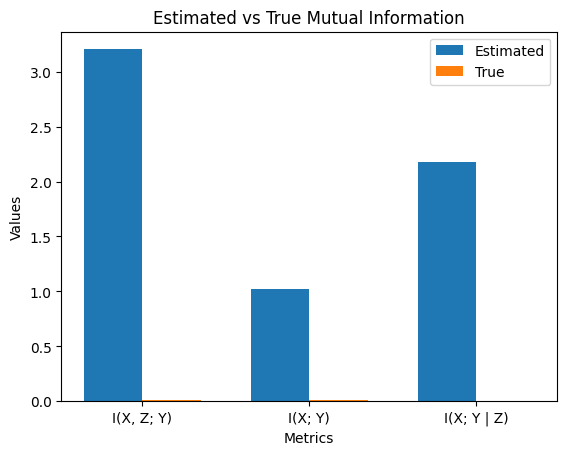

In [3]:
def generate_data(n):
    mu1 = np.array([1, 1, 1, 0, 0]) / 5
    mu2 = np.array([0, 0, 1, 1, 1]) / 5
    Sigma1 = (np.eye(5) * 9 + np.ones((5, 5))) / 10
    Sigma2 = 1.2 * np.eye(5) - np.ones((5, 5)) / 5

    x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
    x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
    x = np.concatenate((x1, x2), axis=0)
    y = np.concatenate((np.ones(n), np.zeros(n)))

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    return x, y


def calculate_true_mi(x, y, bins=20):
    """计算真实的互信息"""
    hist_2d, x_edges, y_edges = np.histogram2d(x, y, bins=bins)
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0  # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))


n = 1000
x, y = generate_data(n)


Z = y


joint_XZ = np.column_stack((x, Z))
I_XZ_Y = estimate_mi(joint_XZ, y, input_dim=joint_XZ.shape[1])


I_X_Y = estimate_mi(x, y, input_dim=x.shape[1])

# 计算条件互信息 I(X; Y | Z)
CMI = I_XZ_Y - I_X_Y

# 计算真实的互信息
true_I_XZ_Y = calculate_true_mi(joint_XZ[:, 0], y)
true_I_X_Y = calculate_true_mi(x[:, 0], y)
true_CMI = true_I_XZ_Y - true_I_X_Y

print(f"Estimated I(X, Z; Y) = {I_XZ_Y}")
print(f"Estimated I(X; Y) = {I_X_Y}")
print(f"Estimated I(X; Y | Z) = {CMI}")

print(f"True I(X, Z; Y) = {true_I_XZ_Y}")
print(f"True I(X; Y) = {true_I_X_Y}")
print(f"True I(X; Y | Z) = {true_CMI}")

# plot
fig, ax = plt.subplots()
categories = ['I(X, Z; Y)', 'I(X; Y)', 'I(X; Y | Z)']
estimated_values = [I_XZ_Y, I_X_Y, CMI]
true_values = [true_I_XZ_Y, true_I_X_Y, true_CMI]

bar_width = 0.35
index = np.arange(len(categories))

bar1 = plt.bar(index, estimated_values, bar_width, label='Estimated')
bar2 = plt.bar(index + bar_width, true_values, bar_width, label='True')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Estimated vs True Mutual Information')
plt.xticks(index + bar_width / 2, categories)
plt.legend()

plt.show()


## Simulated Data

Top 10 important features (true ranking): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 important features (estimated ranking): [12, 4, 6, 5, 3, 16, 7, 8, 17, 0]
Intersection size (simulated): 7


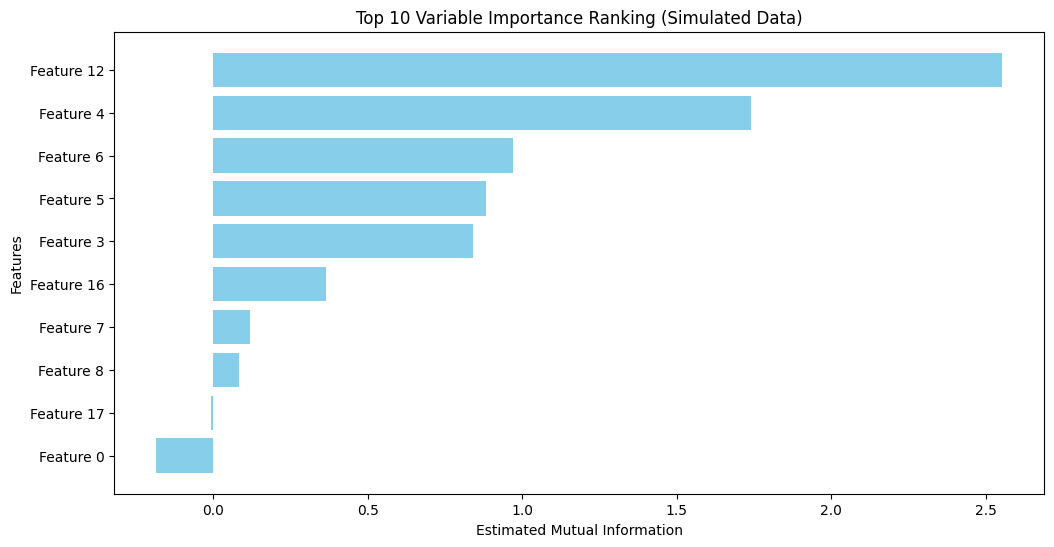

In [4]:
# 生成模拟数据
def generate_simulation_data(n):
    X, y = make_classification(n_samples=n, n_features=20, n_informative=10, random_state=42)
    z = np.random.randn(n, 5)
    return X, y, z

# 排序特征的重要性
def rank_features(X, y, z):
    num_features = X.shape[1]
    mi_estimates = []

    for i in range(num_features):
        xi = X[:, [i]]
        mi = estimate_mi(xi, y, input_dim=xi.shape[1])
        mi_estimates.append((i, mi))

    mi_estimates.sort(key=lambda x: x[1], reverse=True)
    feature_ranking = [i for i, _ in mi_estimates]
    feature_importances = [mi for _, mi in mi_estimates]
    return feature_ranking, feature_importances

# 评估排序质量的函数
def evaluate_ranking(true_ranking, estimated_ranking, k=10):
    true_top_k = set(true_ranking[:k])
    estimated_top_k = set(estimated_ranking[:k])
    intersection_size = len(true_top_k.intersection(estimated_top_k))
    inversions = 0
    for i in range(k):
        for j in range(i + 1, k):
            if true_ranking[i] in estimated_top_k and true_ranking[j] in estimated_top_k:
                idx_i = np.where(estimated_ranking == true_ranking[i])[0][0]
                idx_j = np.where(estimated_ranking == true_ranking[j])[0][0]
                if idx_i > idx_j:
                    inversions += 1
    return intersection_size, inversions

# 示例2：模拟数据的特征排序
X_sim, y_sim, z_sim = generate_simulation_data(n=1000)
feature_ranking_sim, feature_importances_sim = rank_features(X_sim, y_sim, z_sim)

# True ranking based on known informative features
true_ranking_sim = list(range(10)) + list(range(10, 20))

# Compare estimated ranking with true ranking
def compare_rankings(true_ranking, estimated_ranking, k=10):
    true_top_k = set(true_ranking[:k])
    estimated_top_k = set(estimated_ranking[:k])
    intersection_size = len(true_top_k.intersection(estimated_top_k))
    return intersection_size

# Evaluate top-k ranking quality
top_k = 10
intersection_size_sim = compare_rankings(true_ranking_sim, feature_ranking_sim, k=top_k)

print("Top 10 important features (true ranking):", true_ranking_sim[:top_k])
print("Top 10 important features (estimated ranking):", feature_ranking_sim[:top_k])
print("Intersection size (simulated):", intersection_size_sim)

# Plot feature importance ranking for simulated data
features_sim = [f'Feature {i}' for i in feature_ranking_sim[:top_k]]
importance_scores_sim = feature_importances_sim[:top_k]

plt.figure(figsize=(12, 6))
plt.barh(features_sim, importance_scores_sim, color='skyblue')
plt.xlabel('Estimated Mutual Information')
plt.ylabel('Features')
plt.title('Top 10 Variable Importance Ranking (Simulated Data)')
plt.gca().invert_yaxis()
plt.show()

## Real dataset

In [8]:
data = load_diabetes()
X_real = data.data
y_real = data.target
feature_names_real = data.feature_names

# Standardize data
scaler = StandardScaler()
X_real = scaler.fit_transform(X_real)

# Rank features based on mutual information for the real dataset
feature_ranking_real, feature_importances_real = rank_features(X_real, y_real)

# Calculate true ranking based on correlation with the target variable
correlations = np.abs(np.corrcoef(X_real, y_real, rowvar=False)[-1, :-1])
true_ranking_real = np.argsort(-correlations)  # Negative sign for descending order

# Print the top 10 features based on correlation and estimated mutual information
print("Top 10 important features (true ranking by correlation):", [feature_names_real[i] for i in true_ranking_real[:top_k]])
print("Top 10 important features (estimated ranking):", [feature_names_real[i] for i in feature_ranking_real[:top_k]])

# Visualization of true and estimated rankings for the real dataset
plt.figure(figsize=(12, 6))

# True ranking based on correlation
true_features_real = [feature_names_real[i] for i in true_ranking_real[:top_k]]
true_importance_scores_real = correlations[true_ranking_real[:top_k]]



Top 10 important features (true ranking by correlation): ['bmi', 's5', 'bp', 's4', 's3', 's6', 's1', 'age', 's2', 'sex']
Top 10 important features (estimated ranking): ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


<Figure size 1200x600 with 0 Axes>